In [6]:
import math
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt

backend_inline.set_matplotlib_formats('svg')


# The Attention mechanism

Attention mechanism is a way to calculate a weighted average of elements in a sequence, where the weights are dynamically determined based on an input query and the keys associated with each element. The purpose is to compute an average that takes into account the values of the elements, rather than treating them equally.

In simpler terms, the attention mechanism allows us to decide which inputs we should focus on more than others. It consists of four components that need to be specified:

**Query:** The query is a feature vector that represents what we are specifically interested in within the sequence. It describes the aspects or characteristics we want to pay attention to.

**Keys:** Each input element in the sequence has an associated key, which is another feature vector. The key roughly describes what the element offers or indicates its importance. The design of these keys should enable us to identify the elements we want to pay attention to based on the given query.

**Values:** Along with the keys, each input element also has a value vector. This vector represents the actual features or information that we want to compute an average over.

**Score function**: To determine which elements should receive more attention, we need a score function. This function takes both the query and a key as inputs and produces a score or attention weight for the pair. Typically, simple similarity metrics like dot product or a small multi-layer perceptron (MLP) are used to implement the score function.

<br>

*In all, the attention mechanism allows us to dynamically assign weights to elements in a sequence based on their relevance to the query. By doing so, we can focus on important elements and compute a weighted average that takes their values into account.*


# Attention and Databases

Let's draw a comparison to databases. At their core, databases consist of collections of keys and values. To illustrate, consider a simple example database named "People" containing tuples such as {("Shukla", "Mohit"), ("Lipton", "Zachary"), ("Li", "Mu"), ("Smola", "Alex"), ("Singh", "Ranjit")}. Here, the last name serves as the key, while the first name represents the corresponding value.

We can perform operations on this database. For example, if we query the exact match "Li," we would retrieve the value "Mu" associated with it. However, if the record ("Li", "Mu") doesn't exist in the database, we wouldn't receive any valid answer. Alternatively, if we allowed for approximate matches, a query for "Li" might retrieve the record ("Lipton", "Zachary") instead.

Let's consider, a database of tuples of keys and values: $\mathcal{D} \stackrel{\mathrm{def}}{=} \{(\mathbf{k}_1, \mathbf{v}_1), (\mathbf{k}_2, \mathbf{v}_2), \ldots (\mathbf{k}_m, \mathbf{v}_m)\}$. Given a query, q, we can definine attention as:


$\mathrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\mathrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,$

here
 ($\alpha(\mathbf{q}, \mathbf{k}_i) \in \mathbb{R}$
) are scalar attention weights. The operation itself is typically referred to as attention pooling.

<br>

<img src="https://d2l.ai/_images/qkv.svg" style="background-color:white">

<br>

In order to ensure that the weights sum to $1$ and are nonnegative, we use normalize the scores using following:

$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}$



In [7]:
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

Let’s visualize the identity matrix, representing a case where the attention weight is one only when the query and the key are the same.

In [8]:
#Observe: Dimesnions and shape of attention_weights
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
print(attention_weights)


tensor([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]])


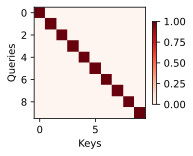

In [9]:
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# Attention Weights

The attention weights are assigned according to the similarity (or distance) between query and key, and according to how many similar observations are available. Typical computation of attention pooling as a weighted average of values, where weights are computed with the attention scoring function
 and the softmax operation looks like:

<img src="https://d2l.ai/_images/attention-output.svg" style="background-color:white">


One the most commonly used attention function that was first used in seminal paper (Vaswani et al.: https://arxiv.org/abs/1706.03762):

$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.$


Here, the dot product between both vectors has zero mean and a variance of  d . To ensure that the variance of the dot product still remains one regardless of vector length, we use the scaled dot-product attention scoring function. That is, we rescale the dot-product by $1/\sqrt{d}$. We thus arrive at the first commonly used attention function that is used


## Masked Softmax Operation

The attention mechanism finds extensive use in sequence models, making it one of the most widely employed applications. Consequently, it becomes necessary to handle sequences of varying lengths. In certain scenarios, these sequences may be grouped together within the same minibatch, requiring the padding of shorter sequences with dummy tokens. These special tokens serve no meaningful purpose. To illustrate, consider the following three sentences:

```
Dive  into  Machine Learning
Learn to write <blank>
Hello world <blank> <blank>
```

Since we do not want blanks in our attention model we simply need to limit $\sum_{i=1}^n \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ to $\sum_{i=1}^l \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ for however long $l \leq n$ the actual sentence is. Since it is such a common problem, it has a name: the *masked softmax operation*.



In [10]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [11]:
#Consider a minibatch of two examples of size  2×4 , where their valid lengths are  2  and  3 , respectively. As a result of the masked softmax operation,
#values beyond the valid lengths for each pair of vectors are all masked as zero.
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.6244, 0.3756, 0.0000, 0.0000],
         [0.4874, 0.5126, 0.0000, 0.0000]],

        [[0.2720, 0.3547, 0.3733, 0.0000],
         [0.2902, 0.2772, 0.4327, 0.0000]]])

## Batch Matrix Multiplication

Another commonly used operation is to multiply batches of matrices with another. This comes in handy when we have minibatches of queries, keys, and values. More specifically, assume that

$$\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b} \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c}
$$

Then the batch matrix multiplication (BMM) computes the element-wise product

$$\mathrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$


In [12]:
def check_shape(a, shape):
    """Check the shape of a tensor.

    Defined in :numref:`sec_rnn-scratch`"""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

In [13]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
check_shape(torch.bmm(Q, K), (2, 3, 6))


## Scaled Dot-Product Attention

Now, let's revisit the dot-product attention mechanism mentioned earlier. Typically, it assumes that both the query and the key vectors have the same length, , denoted as $d$. However, this requirement can be easily handled by introducing a matrix $\mathbf{M}$ that facilitates the translation between these spaces.  Instead of computing $\mathbf{q}^\top \mathbf{k}$ directly, we can utilize $\mathbf{q}^\top \mathbf{M} \mathbf{k}$, where $\mathbf{M}$ is appropriately chosen. It is important to note that, for now, we will assume that the dimensions of the query and key vectors already match.

In practice, we often think in minibatches for efficiency,
such as computing attention for $n$ queries and $m$ key-value pairs,
where queries and keys are of length $d$
and values are of length $v$. The scaled dot-product attention
of queries $\mathbf Q\in\mathbb R^{n\times d}$,
keys $\mathbf K\in\mathbb R^{m\times d}$,
and values $\mathbf V\in\mathbb R^{m\times v}$
thus can be written as

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$


When we apply this approach to a minibatch, it is necessary to utilize the batch matrix multiplication technique that was introduced earlier. In the implementation of the scaled dot product attention that follows, we incorporate dropout as a means of model regularization.

In [14]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

For the purpose of our example we assume that we have a minibatch size of  2 , a total of  10  keys and values, and that the dimensionality of the values is  4 . Lastly, we assume that the valid length per observation is  2  and  6  respectively. Given that, we expect the output to be a  2×1×4  tensor, i.e., one row per example of the minibatch.

In [15]:
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices.

    Defined in :numref:`sec_queries-keys-values`"""
    backend_inline.set_matplotlib_formats('svg')
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(numpy(matrix), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

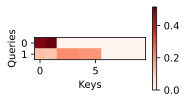

In [16]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## **Additive Attention**

In scenarios where the queries $\mathbf{q}$ and keys $\mathbf{k}$ have different dimensionalities, we have two options. Firstly, we can resolve the mismatch by employing a matrix such as $\mathbf{q}^\top \mathbf{M} \mathbf{k}$. Alternatively, we can utilize additive attention as the scoring function. An additional advantage of additive attention is its additive nature, which can result in slight computational savings.

Given a query $\mathbf{q} \in \mathbb{R}^q$
and a key $\mathbf{k} \in \mathbb{R}^k$,
the *additive attention* scoring function is given by

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$

where $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$,
and $\mathbf w_v\in\mathbb R^{h}$ are the learnable parameters. This term is then fed into a softmax to ensure both nonnegativity and normalization.
An equivalent interpretation of  is that the query and key are concatenated
and fed into an MLP with a single hidden layer.
Using $\tanh$ as the activation function and disabling bias terms,
we implement additive attention as follows:

In [17]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

 We pick queries, keys and values of size  (2,1,20) ,  (2,10,2)  and  (2,10,4) , respectively. This is identical to our choice for DotProductAttention, except that now the queries are  20 -dimensional. Likewise, we pick  (2,6)  as the valid lengths for the sequences in the minibatch.

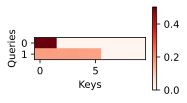

In [18]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# Summary
We presented two essential attention scoring functions: dot product and additive attention. These functions are valuable for consolidating information from sequences that have varying lengths. The dot product attention, in particular, is widely used in modern Transformer architectures. However, when the queries and keys have different vector lengths, the additive attention scoring function can be employed instead. Advancements in optimizing these attention layers have been a significant area of progress in recent years.

# Assignment (optional)

1. How can the dot product attention be modified to handle queries and keys with different dimensionalities by utilizing a matrix to adjust the dimensions?

2. What is the scaling behavior of the computational cost with respect to the dimensionality of the keys, queries, values, and their quantity? Additionally, how does this scaling impact the memory bandwidth requirements?

# References

https://d2l.ai/chapter_attention-mechanisms-and-transformers/